In [4]:
import pandas as pd
import numpy as np
import argparse
import glob
import joblib
# import os

# from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split

CALC_PATHS = '/home/nfs/jludwiczak/af2_cc/af2_multimer/calc'


def get_x(id_: int, rank: int, model: str = "af2", 
          use_pairwise: bool = True):

    single_repr_fns = sorted(glob.glob(f"{CALC_PATHS}/{id_}/*_single_repr_rank_00*"))
    pair_repr_fns = sorted(glob.glob(f"{CALC_PATHS}{id_}/*_pair_repr_rank_00*"))

    mat = np.load(single_repr_fns[rank]).mean(axis=0)
    if use_pairwise:
        mat = np.hstack((mat, np.load(pair_repr_fns[rank]).mean(axis=0).mean(axis=0)))
    return mat

def get_af2_emb(id_: int, model_id: int, use_pairwise: bool):

    single_repr_fns = sorted(glob.glob(f"{CALC_PATHS}/{id_}/*_single_repr_rank_*_model_{model_id+1}_*"))
    pair_repr_fns = sorted(glob.glob(f"{CALC_PATHS}/{id_}/*_pair_repr_rank_*_model_{model_id+1}_*"))


    mat = np.load(single_repr_fns[0]).mean(axis=0)

    if use_pairwise:
        mat = np.hstack((mat, np.load(pair_repr_fns[0]).mean(axis=0).mean(axis=0)))

    return mat



In [2]:
df = pd.read_csv("tests/set4_homooligomers.csv", sep="\t")
df = df.drop_duplicates(subset="full_sequence", keep="first")
df.parallel.unique()

array([False,  True])

In [ ]:
from sklearn.model_selection import KFold, train_test_split

from itertools import product

def train(c=10, balanced=0, dual=1, ensemble_size=1, use_pairwise=True, use_scaler=True):

    df = pd.read_csv("tests/set4_homooligomers.csv", sep="\t")
    df = df.drop_duplicates(subset="full_sequence", keep="first")
    results = np.zeros((ensemble_size, 5, len(df), 2))
    model = {}
    probabilities = []
    for j in range(0, ensemble_size):
        for i in range(0, 5): # 5 since we have 5 AF2 models

            X = np.asarray([get_af2_emb(id_, model_id=i, use_pairwise=use_pairwise) for id_ in df.index])
            y = df['parallel'].values
            cv = KFold(n_splits=5, shuffle=True)

            for k, (tr_idx, te_idx) in enumerate(cv.split(X, y)):

                X_tr, X_te = X[tr_idx], X[te_idx]
                y_tr, y_te = y[tr_idx], y[te_idx]

                if use_scaler == 1:
                    sc = StandardScaler()
                    X_tr = sc.fit_transform(X_tr)
                    X_te = sc.transform(X_te)
                    model[f"scaler_{j}_{i}_{k}"] = sc
                clf = LogisticRegression(C=c, max_iter=1000, solver='liblinear',
                                         dual = False if dual == 0 else True, 
                                         class_weight = 'balanced' if balanced == 1 else None) 
                clf.fit(X_tr, y_tr)
                results[j, i, te_idx] = clf.predict_proba(X_te)
                model[f"clf_{j}_{i}_{k}"] = clf

    y_pred_bin = results.mean(axis=0).mean(axis=0).argmax(axis=1)
    results_ = {}
    results_["accuracy"] = accuracy_score(y, y_pred_bin)
    results_["f1"] = f1_score(y, y_pred_bin, average='macro')

    df["y_pred"] = y_pred_bin
    # df["prob_dimer"] = results.mean(axis=0).mean(axis=0)[:, 0]
    # df["prob_trimer"] = results.mean(axis=0).mean(axis=0)[:, 1]
    # df["prob_tetramer"] = results.mean(axis=0).mean(axis=0)[:, 2]

    return results_, model, df

# c = [1,5,10,15,20]
# balanced = [0,1]
# dual = [0,1]
# ensemble_size = [1,2,3,4,5]
# use_pairwise = [True, False]

# results = []
# for c_, balanced_, dual_, ensemble_size_, use_pairwise_ in product(c, balanced, dual, ensemble_size, use_pairwise):
#     results_, model, df = train(c=c_, balanced=balanced_, dual=dual_, ensemble_size=ensemble_size_, use_pairwise=use_pairwise_)
#     print(results_["accuracy"], results_["f1"])
#     results.append((c_, balanced_, dual_, ensemble_size_, use_pairwise_, results_["accuracy"], results_["f1"]))



In [19]:


def train(c=10, balanced=0, dual=1, ensemble_size=1, use_pairwise=True, use_scaler=True):
    df = pd.read_csv("tests/set4_homooligomers.csv", sep="\t")
    df = df.drop_duplicates(subset="full_sequence", keep="first")
    
    # Initialize results arrays for both target variables
    results_parallel = np.zeros((ensemble_size, 5, len(df), 2))
    results_oligo = np.zeros((ensemble_size, 5, len(df), 3))
    
    model = {}
    for j in range(0, ensemble_size):
        for i in range(0, 5): # 5 since we have 5 AF2 models
            X = np.asarray([get_af2_emb(id_, model_id=i, use_pairwise=use_pairwise) for id_ in df.index])
            
            # Combine target variables into a single array
            y_parallel = df['parallel'].values
            le = LabelEncoder()
            df['oligo_state'] = le.fit_transform(df['chains'])
            y_state = df['oligo_state'].values
            y = np.column_stack((y_parallel, y_state))
            
            cv = KFold(n_splits=5, shuffle=True)
            for k, (tr_idx, te_idx) in enumerate(cv.split(X, y)):
                X_tr, X_te = X[tr_idx], X[te_idx]
                y_tr, y_te = y[tr_idx], y[te_idx]

                if use_scaler == 1:
                    sc = StandardScaler()
                    X_tr = sc.fit_transform(X_tr)
                    X_te = sc.transform(X_te)
                    model[f"scaler_{j}_{i}_{k}"] = sc
                
                # Train and evaluate multi-output model
                clf = MultiOutputClassifier(LogisticRegression(C=c, max_iter=2000, solver='liblinear',
                                         dual=False if dual == 0 else True,
                                         class_weight='balanced' if balanced == 1 else None))
                clf.fit(X_tr, y_tr)
                proba_parallel, proba_chains = clf.predict_proba(X_te)
                results_parallel[j, i, te_idx] = proba_parallel
                results_oligo[j, i, te_idx] = proba_chains
                model[f"clf_{j}_{i}_{k}"] = clf

    # Calculate average probabilities and predicted classes for both target variables
    avg_proba_parallel = results_parallel.mean(axis=0).mean(axis=0)
    avg_proba_state = results_oligo.mean(axis=0).mean(axis=0)
    
    y_pred_bin_parallel = avg_proba_parallel.argmax(axis=1)
    y_pred_bin_state = avg_proba_state.argmax(axis=1)
    
    results_ = {}
    
    # Calculate accuracy and F1 score for parallel target variable
    results_["accuracy_parallel"] = accuracy_score(y_parallel, y_pred_bin_parallel)
    results_["f1_parallel"] = f1_score(y_parallel, y_pred_bin_parallel, average='macro')
    
    # Calculate accuracy and F1 score for chains target variable
    results_["accuracy_oligo_state"] = accuracy_score(y_state, y_pred_bin_state)
    results_["f1_oligo_state"] = f1_score(y_state, y_pred_bin_state, average='macro')

    df["y_pred_parallel"] = y_pred_bin_parallel
    df["y_pred_chains"] = y_pred_bin_state
    df["prob_dimer"] = avg_proba_state[:,0]
    df["prob_trimer"] = avg_proba_state[:,1]
    df["prob_tetramer"] = avg_proba_state[:, 2]
    df["prob_parallel"] = avg_proba_parallel[:, 1]
    df["prob_antiparallel"] = avg_proba_parallel[:, 0]
    df.to_csv('model_results.csv')

    return results_, model, df  


train()


({'accuracy_parallel': 0.7967479674796748,
  'f1_parallel': 0.6657608695652173,
  'accuracy_oligo_state': 0.8333333333333334,
  'f1_oligo_state': 0.8291650132037974},
 {'scaler_0_0_0': StandardScaler(),
  'clf_0_0_0': MultiOutputClassifier(estimator=LogisticRegression(C=10, dual=True,
                                                     max_iter=2000,
                                                     solver='liblinear')),
  'scaler_0_0_1': StandardScaler(),
  'clf_0_0_1': MultiOutputClassifier(estimator=LogisticRegression(C=10, dual=True,
                                                     max_iter=2000,
                                                     solver='liblinear')),
  'scaler_0_0_2': StandardScaler(),
  'clf_0_0_2': MultiOutputClassifier(estimator=LogisticRegression(C=10, dual=True,
                                                     max_iter=2000,
                                                     solver='liblinear')),
  'scaler_0_0_3': StandardScaler(),
  'clf_0_0_

In [20]:
df = pd.read_csv("model/results.csv")
df

,Unnamed: 0,pdb,cc_cov,chains,cc_sequence,full_sequence,full_seq_corr,cc_seq_corr,parallel,y,y_pred,prob_dimer,prob_trimer,prob_tetramer
0,0,3e7k,0.851852,4,TFERVEQMSIQIKEVGDRVNYIKRSLQSLDSQIGHLQDLSALTVDT,SRVTFERVEQMSIQIKEVGDRVNYIKRSLQSLDSQIGHLQDLSALT...,True,False,False,2,2,0.000341,0.271631,0.728028
1,1,1use,0.550000,4,YSDLQRVKQELLEEVKKELQKV,SSDYSDLQRVKQELLEEVKKELQKVKEEIIEAFVQELRKR,False,False,True,2,2,0.057594,0.350967,0.591438
2,2,6us8,0.826087,4,LVVAASIIGILHLILWILD,DPLVVAASIIGILHLILWILDRL,True,False,True,2,2,0.180110,0.005861,0.814029
3,3,5kht,0.893617,2,DAIKKKMQMLKLDKENALDRAEQAEADNYHLENEVARLKKL,GMDAIKKKMQMLKLDKENALDRAEQAEADNYHLENEVARLKKLVGER,False,True,True,0,0,0.892660,0.107131,0.000209
4,4,5c9n,0.671875,2,CSWEEAQLSSQLYRNKQLQDTLVQKEEELARLHEENNHLRQYL,LPDLCSWEEAQLSSQLYRNKQLQDTLVQKEEELARLHEENNHLRQY...,True,False,True,0,0,0.993330,0.003242,0.003428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,243,5kb1,0.888889,3,WEALEKKLAALESKCQALEKKLQALEKKHEAL,EWEALEKKLAALESKCQALEKKLQALEKKHEALEHG,False,False,True,1,1,0.009052,0.988137,0.002811
242,244,4h22,0.876543,2,YKKAMVSNAQLDNEKTNFMYQVDTLKDMLLELEEQLAESRRQYEEK...,EEKYKKAMVSNAQLDNEKTNFMYQVDTLKDMLLELEEQLAESRRQY...,True,False,True,0,0,0.997990,0.000245,0.001765
243,245,1kyc,0.800000,3,LRRRIEELERRI,EELRRRIEELERRIR,False,False,True,1,1,0.000002,0.713107,0.286891
244,246,2zfc,0.909091,3,LVQQQNNILRALEATQHAVQALVWGVKQLQARVLALERYI,VSGLVQQQNNILRALEATQHAVQALVWGVKQLQARVLALERYIK,False,False,True,1,1,0.010096,0.872688,0.117216


<AxesSubplot:>

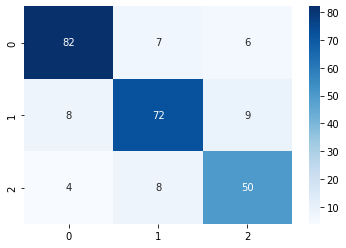

In [12]:
from sklearn.metrics import confusion_matrix
import  seaborn as sns
confusion_matrix(df.parallel, df.y_pred_parallel)
# sns.heatmap(confusion_matrix(df.parallel, df.y_pred_parallel), annot=True, cmap="Blues", fmt="d")
confusion_matrix(df.oligo_state, df.y_pred_chains)
sns.heatmap(confusion_matrix(df.oligo_state, df.y_pred_chains), annot=True, cmap="Blues", fmt="d")

In [16]:
df = pd.read_csv("new_model_results.csv")
le = LabelEncoder()
df['parallel_code'] = le.fit_transform(df['parallel'])
df[['pdb','parallel_code','parallel']].loc[df.pdb == '4dzo'].head(10)

,pdb,parallel_code,parallel
